In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import datasets

# 12.1 Principal Compoent Analysis

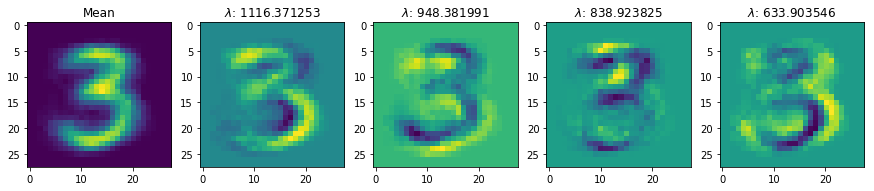

In [5]:
N = 600
data = pickle.load(open('./data.txt', 'rb'))
x_train = data['x_train']
y_train = data['y_train']
x = x_train[np.random.choice(np.where(y_train == 3)[0], 200)]
mean = np.mean(x, axis=0).reshape(1,-1)
plt.figure(figsize=[15,5])
plt.subplot(1,5,1)
plt.imshow(mean.reshape(28,28))
plt.title('Mean')

new_x = x-mean
S, sigma, V = np.linalg.svd(new_x.T)
for i in range(4):
    plt.subplot(1, 5, i+2)
    plt.imshow(S[:,i].reshape(28,28))
    plt.title('$\lambda$: %f'%sigma[i]**2)

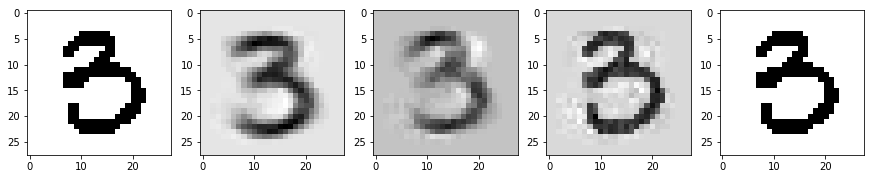

In [6]:
plt.figure(figsize=[15,5])
plt.subplot(1,5,1)
x1 = x[2,:]
plt.imshow(x1.reshape(28,28), cmap='gray_r')
idx = np.array([1,10,50,250])
for i in range(4):
    rec_x = mean + new_x[2,:].reshape(1,-1)@S[:,0:idx[i]]@S[:,0:idx[i]].T
    plt.subplot(1, 5, i+2)
    plt.imshow(rec_x.reshape(28,28), cmap='gray_r')

# 12.2.2 EM algorithm for PCA

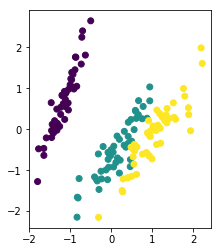

In [47]:
iris = datasets.load_iris()
data = iris.data
y = iris.target.reshape(-1,1)

# EM algorithm
max_iter = 100
n,d = data.shape
X = data - data.mean(axis=0)
n_components = 2
I = np.eye(n_components)
W = np.eye(d, n_components)
var = 1.

for i in range(max_iter):
#     E-Step
    M = W.T @ W + var*I
    inv_M = np.linalg.inv(M)
    Ez = X @ W  @ inv_M
    Ezz = var * inv_M + Ez[:,:,None] * Ez[:,None,:]
    
#     M-Step
    W = X.T @ Ez @ np.linalg.inv(Ezz.sum(axis=0))
    var = np.mean(np.mean(X**2, axis=1) - 2*np.mean(Ez @ W.T*X, axis=1) + np.trace((Ezz @ W.T @ W).T) / np.size(X, 1))
    
C = W @ W.T + var * np.eye(d)
inv_C = np.linalg.inv(C)

proj_X = np.linalg.solve(M, (X @ W).T).T

plt.figure()
plt.scatter(proj_X[:,0], proj_X[:,1], c=y.flatten())
plt.gca().set_aspect('equal', adjustable='box')

# 12.2.3 Bayesian PCA

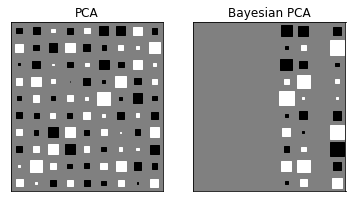

In [78]:
def create_toy_data(sample_size=100, ndim_hidden=1, ndim_observe=2, std=1.):
    Z = np.random.normal(size=(sample_size, ndim_hidden))
    mu = np.random.uniform(-5, 5, size=(ndim_observe))
    W = np.random.uniform(-5, 5, (ndim_hidden, ndim_observe))

    X = Z.dot(W) + mu + np.random.normal(scale=std, size=(sample_size, ndim_observe))
    return X

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([y - size / 2, x - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()
    plt.xlim(-0.5, np.size(matrix, 1) - 0.5)
    plt.ylim(-0.5, len(matrix) - 0.5)


data = create_toy_data(sample_size=100, ndim_hidden=3, ndim_observe=10, std=1.)


# EM algorithm
max_iter = 100
n,d = data.shape
X = data - data.mean(axis=0)
n_components = 9
I = np.eye(n_components)
W = np.eye(d, n_components)
var = 1.

for i in range(max_iter):
#     E-Step
    M = W.T @ W + var*I
    inv_M = np.linalg.inv(M)
    Ez = X @ W  @ inv_M
    Ezz = var * inv_M + Ez[:,:,None] * Ez[:,None,:]
    
#     M-Step
    W = X.T @ Ez @ np.linalg.inv(Ezz.sum(axis=0))
    var = np.mean(np.mean(X**2, axis=1) - 2*np.mean(Ez @ W.T*X, axis=1) + np.trace((Ezz @ W.T @ W).T) / np.size(X, 1))
    
C = W @ W.T + var * np.eye(d)
inv_C = np.linalg.inv(C)

proj_X = np.linalg.solve(M, (X @ W).T).T

plt.figure()
plt.subplot(1,2,1)
plt.title("PCA")
hinton(W)

# EM algorithm
max_iter = 1000
n,d = X.shape
X = data - data.mean(axis=0)
mean = data.mean(axis=0)
n_components = 9
I = np.eye(n_components)
W = np.eye(d, n_components)
var = 1.
alpha = len(mean) / np.sum(W ** 2, axis=0).clip(min=1e-10)

for i in range(max_iter):
#     E-Step
    M = W.T @ W + var*I
    inv_M = np.linalg.inv(M)
    Ez = X @ W  @ inv_M
    Ezz = var * inv_M + Ez[:,:,None] * Ez[:,None,:]
    
#     M-Step
    W = X.T @ Ez @ np.linalg.inv(Ezz.sum(axis=0) + var*np.diag(alpha))
    var = np.mean(np.mean(X**2, axis=-1) - 2*np.mean(Ez @ W.T*X, axis=-1) + np.trace((Ezz @ W.T @ W).T) / np.size(X, 1))
    alpha = len(mean) / np.sum(W ** 2, axis=0).clip(min=1e-10)
        
plt.subplot(1,2,2)

plt.title("Bayesian PCA")
hinton(W)

# 12.4.1 indenpendent component analysis

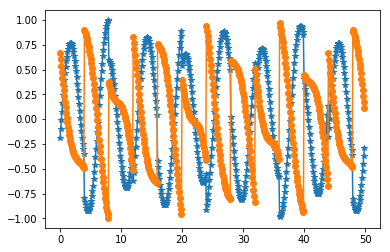

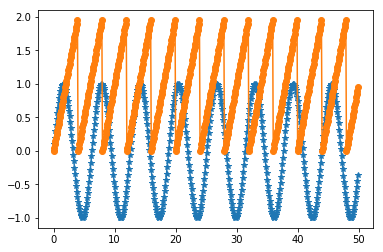

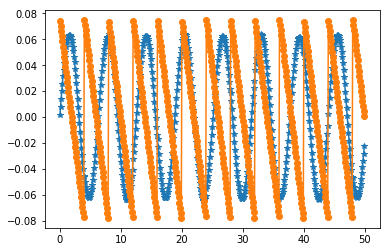

In [79]:
import math
import random
import matplotlib.pyplot as plt
from numpy import *

n_components = 2

def f1(x, period = 4):
    return 0.5*(x-math.floor(x/period)*period)

def create_data():
    #data number
    n = 500
    #data time
    T = [0.1*xi for xi in range(0, n)]
    #source
    S = array([[sin(xi)  for xi in T], [f1(xi) for xi in T]], float32)
    #mix matrix
    A = array([[0.8, 0.2], [-0.3, -0.7]], float32)
    return T, S, dot(A, S)

def whiten(X):
    #zero mean
    X_mean = X.mean(axis=-1)
    X -= X_mean[:, newaxis]
    #whiten
    A = dot(X, X.transpose())
    D , E = linalg.eig(A)
    D2 = linalg.inv(array([[D[0], 0.0], [0.0, D[1]]], float32))
    D2[0,0] = sqrt(D2[0,0]); D2[1,1] = sqrt(D2[1,1])
    V = dot(D2, E.transpose())
    return dot(V, X), V

def _logcosh(x, fun_args=None, alpha = 1):
    gx = tanh(alpha * x, x); g_x = gx ** 2; g_x -= 1.; g_x *= -alpha
    return gx, g_x.mean(axis=-1)

def do_decorrelation(W):
    #black magic
    s, u = linalg.eigh(dot(W, W.T))
    return dot(dot(u * (1. / sqrt(s)), u.T), W)

def do_fastica(X):
    n, m = X.shape; p = float(m); g = _logcosh
    #black magic
    X *= sqrt(X.shape[1])
    #create w
    W = ones((n,n), float32)
    for i in range(n): 
        for j in range(i):
            W[i,j] = random.random()

    #compute W
    maxIter = 200
    for ii in range(maxIter):
        gwtx, g_wtx = g(dot(W, X))
        W1 = do_decorrelation(dot(gwtx, X.T) / p - g_wtx[:, newaxis] * W)
        lim = max( abs(abs(diag(dot(W1, W.T))) - 1) )
        W = W1
        if lim < 0.0001:
            break
    return W

def show_data(T, S):
    plt.plot(T, [S[0,i] for i in range(S.shape[1])], marker="*")
    plt.plot(T, [S[1,i] for i in range(S.shape[1])], marker="o")
    plt.show()

def main():
    T, S, D = create_data()
    Dwhiten, K = whiten(D)
    W = do_fastica(Dwhiten)
    #Sr: reconstructed source
    Sr = dot(dot(W, K), D)
    show_data(T, D)
    show_data(T, S)
    show_data(T, Sr)

if __name__ == "__main__":
    main()    